# Multi-condition Sparse FBA (small simulation)

Most of the experiments in the manuscript describing CORNETO require a valid GUROBI license. To avoid this issue, and for completeness, we provide here a small example of single/multi-condition Sparse FBA that can be reproduced using the open source solver SCIP


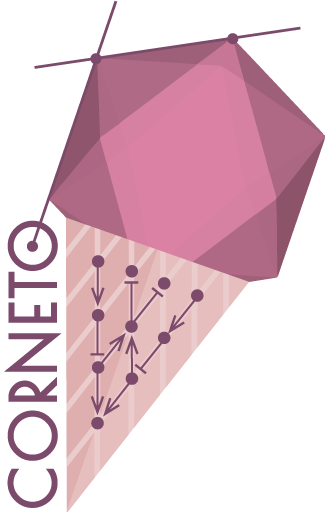

In [1]:
import corneto as cn
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sns
import os

pal = sns.color_palette("muted")

cn.info()

In [2]:
sns.set_palette(pal)
solver = "SCIP"
tol = 1e-6

CORNETO provides a way to import metabolic networks in different formats. Here, we import the MitoCore v1.0.1 (https://www.mrc-mbu.cam.ac.uk/research-resources-and-facilities/mitocore) from a collection of numpy compressed metabolic networks (https://github.com/pablormier/miom-gems/)

In [3]:
G = cn.Graph.from_miom_model("https://github.com/pablormier/miom-gems/raw/refs/heads/main/gems/mitocore/v1.0.1/default.miom")
G.shape

(441, 555)

In [4]:
rxn_obj_id = next(G.get_edges_by_attr("id", "EX_biomass_e"))
rxn_obj_id

12

The FBA problem is very simple to implement using CORNETO's framework. It requires to use the `Flow` problem and passing the graph, as well as lower/upper bounds for its edges (reactions). The `values=True` indicates to import the values (in this case, stoichiometric coefficients) when building the flow problem.  

In [5]:
def corneto_fba(G, rxn_obj=None, min_flux=None, sparse=False):
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=1)
    F = P.expr.flow
    if sparse:
        # Indicator creates a new binary variable vector (_flow_i)
        # where each position of the vector indicates if the flux
        # of the reaction is unblocked or not. Minimising this
        # vector is eq. to blocking (removing) as many reactions as
        # possiblE
        P += cn.opt.Indicator(F)
        P.add_objectives(sum(P.expr._flow_i))
    if rxn_obj is not None:
        if isinstance(rxn_obj, str):
            rxn_obj = next(G.get_edges_by_attr("id", rxn_obj))
        if min_flux is not None:
            P += F[rxn_obj] >= min_flux
        P.add_objectives(-F[rxn_obj])
    return P

problem = corneto_fba(G, rxn_obj=rxn_obj_id)
problem.solve(solver=solver)
opt_flux = problem.expr.flow[rxn_obj_id].value
opt_flux

100.89230387215554

In [6]:
len(np.flatnonzero(np.abs(problem.expr.flow.value)))

229

In [7]:
np.sum(np.abs(problem.expr.flow.value)>=1e-6)

227

In [8]:
problem = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
problem.solve(solver=solver)
nrxns_min = np.sum(np.abs(problem.expr.flow.value)>=tol)
nrxns_min

214

In [9]:
# We import a preocomputed CSV indicating the impact of removing (KO)
# that reaction from the model in the production of biomass.
# We use this as a pool of interesting KOs to randomly build multi-samples
# (sets of single-KO strains for analysing with the multi-sample sparse FBA)
df_ko_result = pd.read_csv('mitocore.csv').set_index('i')
ko_result = [(r.i, r.id, r.opt_flux, r.min_rxn) for (_, r) in df_ko_result.reset_index().iterrows()]
ko_result

[(0, 'EX_2hb_e', 100.89230387215594, 207.00004384651027),
 (1, 'EX_ac_e', 100.89230387215562, 207.00004380812305),
 (2, 'EX_acac_e', 100.80501513081464, 204.00004381517303),
 (3, 'EX_akg_e', 100.89230387215564, 207.0000438261111),
 (4, 'EX_ala_B_e', 100.89230387215557, 207.00004384011083),
 (5, 'EX_ala_L_e', 100.87799359723672, 205.00004374560567),
 (6, 'EX_arg_L_e', 100.87501109771534, 204.00000586641528),
 (7, 'EX_argsuc_e', 100.89230387215562, 207.00004380846),
 (8, 'EX_asn_L_e', 100.87529089453396, 204.0000438372241),
 (9, 'EX_asp_L_e', 100.62629856007646, 204.0000533105055),
 (10, 'EX_bhb_e', 100.8344159682852, 203.0000438310217),
 (11, 'EX_bilirub_e', 100.89230387215562, 207.00004387512104),
 (12, 'EX_biomass_e', 0.0, 0.0),
 (13, 'EX_but_e', 100.89230387215554, 207.00004380825368),
 (14, 'EX_chol_e', 100.89230387215564, 207.0000438228255),
 (15, 'EX_cit_e', 100.89230387215564, 207.0000438520879),
 (16, 'EX_citr_L_e', 100.89230387215564, 207.00004380846),
 (17, 'EX_co_e', 100.8923

In [10]:
# Simulations on MitoCore performing single KOs. This is done to find
# the reactions that have some impact on biomass production, as candidates for
# the multi-condition simulation
ko_result

[(0, 'EX_2hb_e', 100.89230387215594, 207.00004384651027),
 (1, 'EX_ac_e', 100.89230387215562, 207.00004380812305),
 (2, 'EX_acac_e', 100.80501513081464, 204.00004381517303),
 (3, 'EX_akg_e', 100.89230387215564, 207.0000438261111),
 (4, 'EX_ala_B_e', 100.89230387215557, 207.00004384011083),
 (5, 'EX_ala_L_e', 100.87799359723672, 205.00004374560567),
 (6, 'EX_arg_L_e', 100.87501109771534, 204.00000586641528),
 (7, 'EX_argsuc_e', 100.89230387215562, 207.00004380846),
 (8, 'EX_asn_L_e', 100.87529089453396, 204.0000438372241),
 (9, 'EX_asp_L_e', 100.62629856007646, 204.0000533105055),
 (10, 'EX_bhb_e', 100.8344159682852, 203.0000438310217),
 (11, 'EX_bilirub_e', 100.89230387215562, 207.00004387512104),
 (12, 'EX_biomass_e', 0.0, 0.0),
 (13, 'EX_but_e', 100.89230387215554, 207.00004380825368),
 (14, 'EX_chol_e', 100.89230387215564, 207.0000438228255),
 (15, 'EX_cit_e', 100.89230387215564, 207.0000438520879),
 (16, 'EX_citr_L_e', 100.89230387215564, 207.00004380846),
 (17, 'EX_co_e', 100.8923

In [11]:
intervention_obj_effect = {k_id: flux for k_id, _, flux, _ in ko_result}

In [12]:
# Show some interesting interventions
subset_interventions = []
for k_id, r_id, opt_ko_flux, n_rxns in ko_result:
    if abs(n_rxns - nrxns_min) > 10 and opt_ko_flux > 1e-3 and opt_ko_flux <= 0.999*opt_flux:
        print(k_id, r_id, opt_ko_flux, n_rxns)
        subset_interventions.append(k_id)

18 EX_co2_e 12.916868239866858 181.00004599129625
26 EX_glc_D_e 97.40185979214648 201.00004388426865
31 EX_h_e 99.341099932917 190.00004187440737
32 EX_h2o_e 84.27054152662792 177.0000607741228
35 EX_hdca_e 49.91050423765515 272.0000708135958
47 EX_nh4_e 100.4794679320681 129.0000019452489
49 EX_o2_e 1.846509909909828 102.00003696679973
70 OF_ATP_MitoCore 12.386111111110871 224.00007999359536
74 HEX1 97.40185979214648 201.00004388426865
76 PGI 97.84603900999088 237.0000563006875
80 TPI 97.43093092183904 201.00004736414124
81 GAPD 97.38249779574096 192.00004383995991
82 PGK 97.38249779574096 192.00004383995991
97 PDHm 98.4927588944543 194.0000768734728
98 CSm 6.581457531655777 186.00006398705256
99 ACONTm 99.0374844711101 198.00006285265715
100 ICDHxm 95.94602724560954 197.00005630237197
106 MDHm 27.885252871451897 185.0000511933078
107 CI_MitoCore 69.89555499412448 174.00004743747257
108 CII_MitoCore 26.08194145314042 232.000059943765
109 CIII_MitoCore 2.1026237244533106 141.0000559108

In [13]:
len(subset_interventions)

43

Find a network with some characteristics (e.g production of biomass) and the networks for each intervention. Assumption is that each alt. network after intervention has min. distance wrt the control network.

In [14]:
# Modification of the Sparse FBA with support for blocking reactions
def singlesparse_fba(G, interventions, obj_rxn=rxn_obj_id, opt_ko=None, prop_opt_ko=1.0, max_time=300, verbose=True):
    models = []
    S = np.zeros((G.shape[1], len(interventions)))
    F = np.zeros((G.shape[1], len(interventions)))
    for i, kid in enumerate(interventions):
        opt_flux = 0
        if opt_ko is not None:
            print(i, kid, prop_opt_ko * opt_ko[kid])
            opt_flux = prop_opt_ko*opt_ko[kid]
        pf = corneto_fba(G, rxn_obj=rxn_obj_id, min_flux=opt_flux, sparse=True)
        pf += pf.expr._flow_i[kid] == 0
        pf += pf.expr.flow[kid] == 0
        pf.solve(solver=solver, verbosity=int(verbose), max_seconds=max_time)
        S[:, i] = (np.abs(pf.expr.flow.value) >= tol).astype(int)
        F[:, i] = pf.expr.flow.value
        models.append(pf)
    return S, F

In [15]:
# For completion, we provide here the full code of the multi-sparse FBA

def multisparse_fba(G, interventions, obj_rxn=rxn_obj_id, alpha=1e-2, 
                    multi=True, opt_ko=None, prop_opt_ko=1.0, use_and=False, 
                    verbose=True, max_time=300, smodels=None, gap=0, min_or=False):
    # Maximize fba per intervention minimizing the distance across networks
    conditions = len(interventions)
    lb = np.array(G.get_attr_from_edges("default_lb"))
    ub = np.array(G.get_attr_from_edges("default_ub"))
    P = cn.opt.Flow(G, lb=lb, ub=ub, values=True, n_flows=conditions)
    P += cn.opt.Indicator(P.expr.flow)
    selected = []
    for i in range(conditions):
        F = P.expr._flow[:, i]
        sel = P.expr._flow_i[:, i]
        intv = interventions[i]
        # maximize biomass (if no info about opt ko)
        if opt_ko is None:
            P.add_objectives(-F[obj_rxn])
        else:
            print(f"Intervention: {intv}, FBA sol = {opt_ko[intv]}, FBA sol {prop_opt_ko*100}% = {prop_opt_ko * opt_ko[intv]}")
            #print(intv, prop_opt_ko * opt_ko[intv])
            P += F[obj_rxn] >= prop_opt_ko * opt_ko[intv]
        # Block flux on intervened reaction
        P += sel[intv] == 0 # blocked
        P += F[intv] == 0
        selected.append(sel)
        if not multi:
            P.add_objectives(sum(sel), weights=alpha)
    if alpha > 0:
        total = sum(selected)
        if min_or:
            # Old implementation
            logic_or = cn.K.Variable(name='_or', shape=total.shape, vartype=cn.VarType.BINARY)
            P += [
                # only 0 if total is 0
                logic_or >= total/conditions,
                logic_or <= total
            ]
            P.add_objectives(sum(logic_or), weights=alpha)
        else:
            P += cn.opt.linear_or(P.expr._flow_i, axis=1, varname="Y")
            P.add_objectives(sum(P.expr.Y), weights=alpha)
    warm_start = smodels != None    
    P.solve(solver=solver, verbosity=int(verbose), max_seconds=max_time)
    return P, selected


## Experiments

Sparse FBA tries to find the smallest flux consistent metabolic network that is able to attain a particular objective. For multiple conditions, taking the union of one sparse FBA per condition do not achieve optimal results. Here we show how multi-condition sparse FBA can find better networks by integrating information from multiple conditions.

We show this first for a given set of interventions, assuming we know the optimal possible FBA solution per KO.

In [16]:
np.random.seed(42)
prop_opt_ko = 0.95
timelimit=600
verbose=True
reps=1
sizes = [2, 3,4]

# Generate experiments
experiments = []
for size in sizes:
    for i in range(reps):
        sel_ids = np.random.choice(subset_interventions, size, replace=False)
        experiments.append((size, i, sel_ids))

df_experiments = pd.DataFrame(experiments, columns=["size", "rep", "intv_ids"])
df_experiments

,size,rep,intv_ids
0,2,0,"[483, 170]"
1,3,0,"[31, 18, 485]"
2,4,0,"[99, 32, 440, 410]"


In [17]:
def run_experiments(experiments, prop_opt_ko=prop_opt_ko, alpha=1.0, min_or=False):
    results = []
    for i, r in experiments.iterrows():
        sel_ids = r.intv_ids
        print(f"k={r.size} (row {i}), selected interventions: {sel_ids}")
        print("- Running single...")
        Ns, Fs = singlesparse_fba(G, sel_ids, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko, verbose=False)
        rxn_single = sum(np.sum(Ns, axis=1) > 0)
        print("- Running multi...")
        Mm = multisparse_fba(G, sel_ids, alpha=alpha, multi=True, verbose=verbose, min_or=min_or,
                             max_time=timelimit, opt_ko=intervention_obj_effect, prop_opt_ko=prop_opt_ko)
        Nm = (np.abs(Mm[0].expr.flow.value) >= tol).astype(int)
        Fm = Mm[0].expr.flow.value
        rxn_multi = sum(np.mean(Nm, axis=1) > 0)
        results.append((i, Ns, Fs, Nm, Fm, rxn_single, rxn_multi))
        print(f"N. conditions = {size}, Inferred network size: single={rxn_single}, multi={rxn_multi}")
    return results

In [18]:
def get_df_results(df_experiments, results):
    r_values = []
    for (i, r), res in zip(df_experiments.iterrows(), results):
        r_values.append((len(r.intv_ids), r.rep, res[-1], res[-2]))
    df = pd.DataFrame(r_values, columns=['size_interv', 'rep', 'multi', 'single'])
    return df

In [20]:
def calc_props(results):
    selected_single = []
    selected_multi = []
    for r in results:
        _, result_single, _, result_multi, _, _, _ = r
        selected_multi.append(result_multi)
        selected_single.append(result_single)
    prop_rxn_single = np.concatenate(selected_single, axis=1).mean(axis=1)
    prop_rxn_multi = np.concatenate(selected_multi, axis=1).mean(axis=1)
    df_proportions = pd.DataFrame(
        {'rxn': G.get_attr_from_edges("id"), 'rxn_prop_single': prop_rxn_single, 'rxn_prop_multi': prop_rxn_multi}
    ).set_index("rxn").sort_values(by="rxn_prop_multi", ascending=False)
    return df_proportions


In [24]:
results_90 = run_experiments(df_experiments, prop_opt_ko=0.90)

k=3 (row 0), selected interventions: [483 170]
- Running single...
0 483 11.625181415880173
1 170 43.44345626211539
- Running multi...
Intervention: 483, FBA sol = 12.916868239866858, FBA sol 90.0% = 11.625181415880173
Intervention: 170, FBA sol = 48.27050695790599, FBA sol 90.0% = 43.44345626211539
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 14 01:12:04 AM: Your problem has 2775 variables, 6566 constraints, and 0 parameters.
(CVXPY) Jan 14 01:12:04 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 14 01:12:04 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 14 01:12:04 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 14 01:12:04 AM: Your problem is compiled with the CPP canonicalization backend.
------

/Users/pablorodriguezmier/miniforge3/envs/corneto-saeztools/lib/python3.11/site-packages/cvxpy/problems/problem.py:1481: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


2 485 87.66167381293184
- Running multi...
Intervention: 31, FBA sol = 99.341099932917, FBA sol 90.0% = 89.4069899396253
Intervention: 18, FBA sol = 12.916868239866858, FBA sol 90.0% = 11.625181415880173
Intervention: 485, FBA sol = 97.40185979214648, FBA sol 90.0% = 87.66167381293184
                                     CVXPY                                     
                                     v1.6.0                                    
(CVXPY) Jan 14 02:10:12 AM: Your problem has 3885 variables, 9390 constraints, and 0 parameters.
(CVXPY) Jan 14 02:10:12 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 14 02:10:12 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 14 02:10:12 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 14 02:10:12 AM: Your problem is compiled with the CPP canonicalization backend.
---------------------

Text(0, 0.5, 'Number of different reactions in the network')

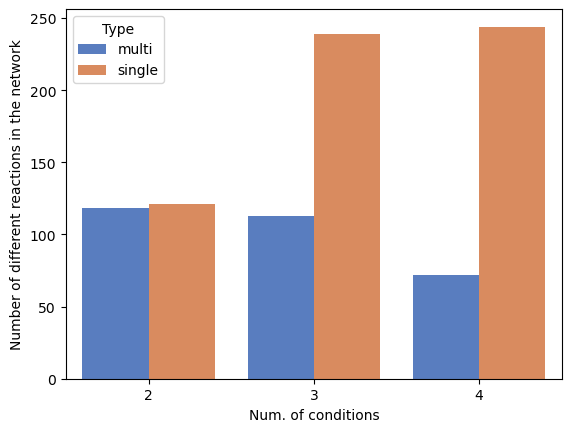

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

df_res = get_df_results(df_experiments, results_90)
df_res = df_res.melt(id_vars="size_interv", value_vars=["multi", "single"], var_name="Type", value_name="Value")
sns.barplot(data=df_res, x="size_interv", hue="Type", y="Value")
plt.xlabel("Num. of conditions")
plt.ylabel("Number of different reactions in the network")

In [40]:
# Average reduction in size
def reduction(results):
    reductions = []
    for r in results:
        M = r[-1]
        S = r[-2]
        reduction = ((S-M)/S)*100
        reductions.append(reduction)
    return np.mean(reductions)

In [42]:
reduction(results_90)

41.89693579787676